# Preparación del Dataset GTZAN

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Definir ruta del dataset
general_path = "Data"
data_path = f"{general_path}/genres_original"

# Verificar estructura del dataset
print("Estructura del dataset:")
print(f"Ruta principal: {data_path}")

# Listar géneros disponibles
genres = [genre for genre in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, genre))]
print(f"\nGéneros encontrados: {genres}")
print(f"Total de géneros: {len(genres)}")

# Contar archivos por género
genre_counts = {}
total_files = 0

for genre in genres:
    genre_path = os.path.join(data_path, genre)
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    genre_counts[genre] = len(files)
    total_files += len(files)
    print(f"{genre}: {len(files)} archivos")

print(f"\nTotal de archivos: {total_files}")

Estructura del dataset:
Ruta principal: Data/genres_original

Géneros encontrados: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total de géneros: 10
blues: 100 archivos
classical: 100 archivos
country: 100 archivos
disco: 100 archivos
hiphop: 100 archivos
jazz: 100 archivos
metal: 100 archivos
pop: 100 archivos
reggae: 100 archivos
rock: 100 archivos

Total de archivos: 1000


In [3]:
# Importamos un archivo
sample_y, sample_sr = librosa.load(f'{data_path}/hiphop/hiphop.00033.wav')

In [4]:
def track_by_gender(genre_folder):
    """
    Devuelve la ruta de la pista .wav encontrada en la carpeta del género.
    """
    for f in sorted(os.listdir(genre_folder)):
        if f.endswith(".wav"):
            return os.path.join(genre_folder, f)
    raise FileNotFoundError("No se encontró archivo .wav en " + genre_folder)

## Onda de sonido (Sound Waves)
Representa la amplitud de la señal en el dominio temporal.

Permite ubicar silencios, golpes fuertes, ataques y dinámica general.

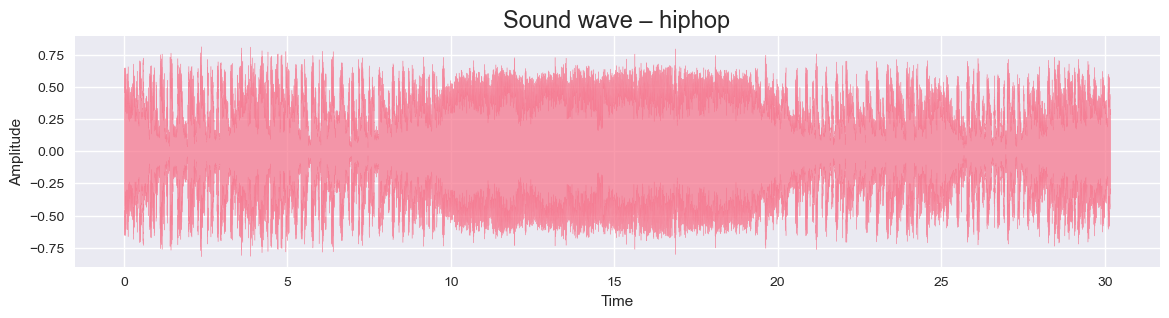

In [5]:
def show_soundwave(y, sr, genre):
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.7)
    plt.title(f"Sound wave – {genre}", fontsize = 17)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

show_soundwave(sample_y, sample_sr, 'hiphop')

## Short-time Fourier transform (STFT)
Transforma la señal al dominio frecuencia → muestra cuánta energía hay en cada banda.

Ayuda a detectar graves predominantes, presencia de platillos, formantes vocales, etc.

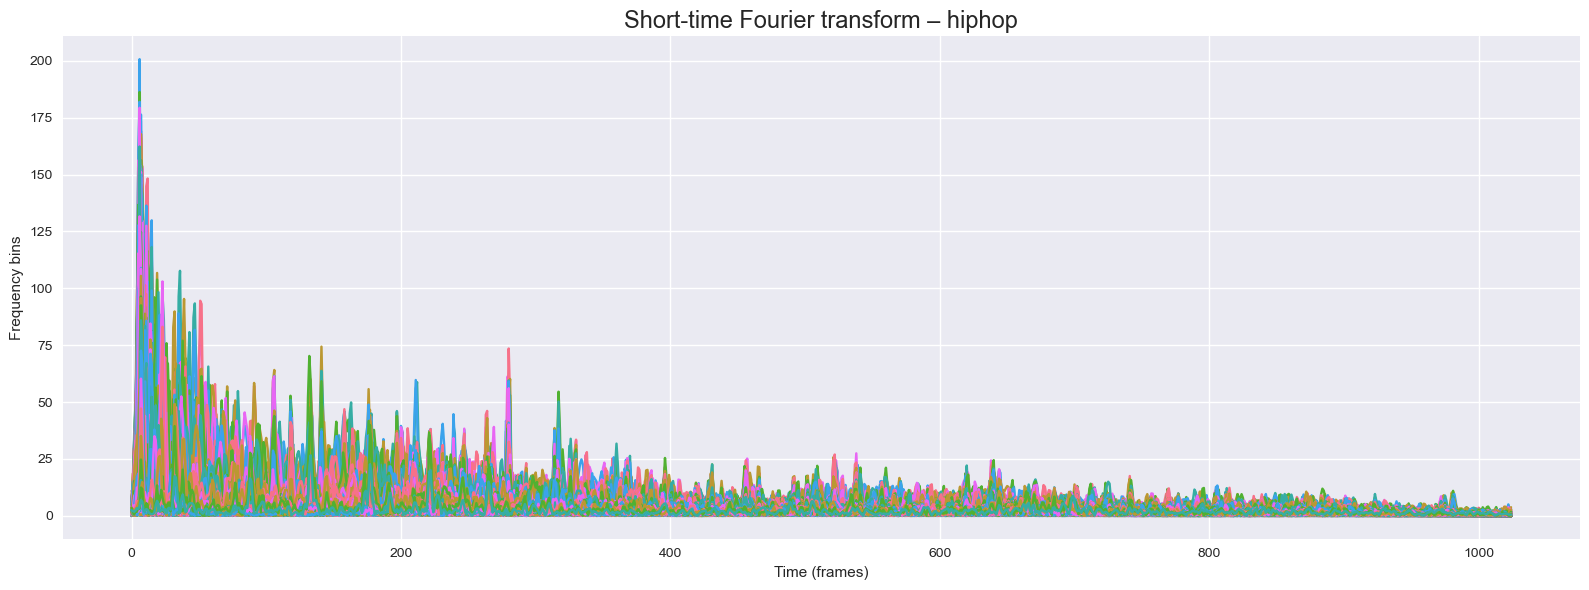

In [6]:
def show_stft(y, genre):
    # FFT simple de toda la señal
    n_fft = 2048 # Tamaño de la ventana FFT
    hop_length = 512 # Número audio de fotogramas entre columnas STFT
    
    audio_file, _ = librosa.effects.trim(y)
    
    D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))
    
    plt.figure(figsize = (16, 6))
    plt.title(f"Short-time Fourier transform – {genre}", fontsize = 17)
    plt.plot(D)
    plt.xlabel("Time (frames)")
    plt.ylabel("Frequency bins")
    plt.tight_layout()

show_stft(sample_y, 'hiphop')

## Mel Spectrogram
Espectrograma en escala Mel, aproximando la percepción humana.

Visualiza cómo evoluciona la energía por bandas perceptuales; útil para ver patrones rítmico-armónicos.

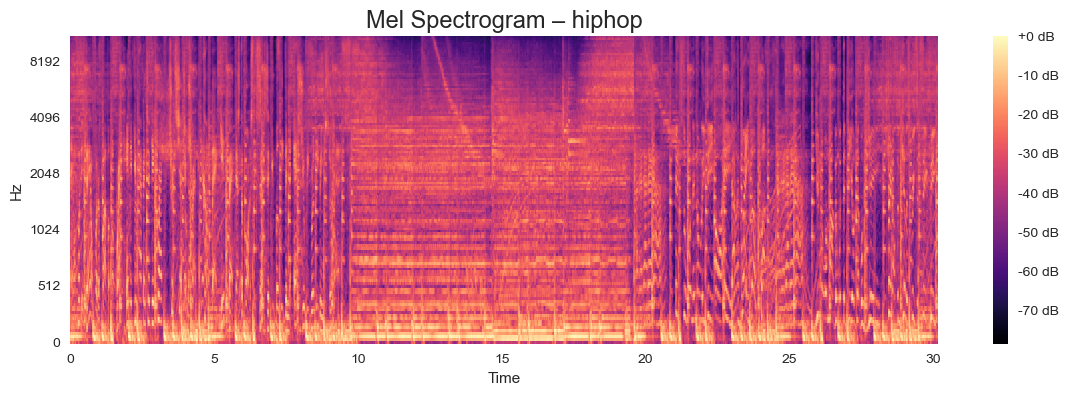

In [7]:
def show_mel_spectogram(y, sr, genre):
    S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = 128, hop_length = 512)
    S_dB = librosa.power_to_db(S, ref = np.max)
    
    plt.figure(figsize = (14, 4))
    librosa.display.specshow(S_dB, sr = sr, hop_length=512, x_axis = 'time', y_axis = 'mel', cmap = 'magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram – {genre}", fontsize = 17)
    plt.show()

show_mel_spectogram(sample_y, sample_sr, 'hiphop')

## Zero Crossing Rate
Número de veces que la señal cruza el eje cero por frame.

Diferencia secciones ruidosas/percusivas (alto ZCR) de suaves/tonales (bajo ZCR).

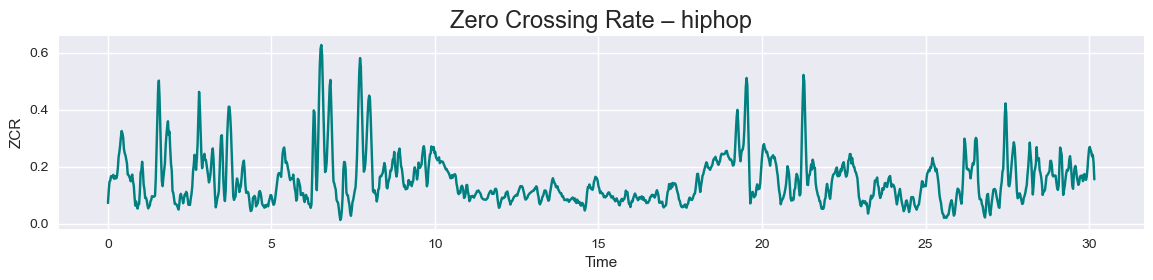

In [8]:
def show_zcr(y, sr, genre):
    zcr = librosa.feature.zero_crossing_rate(y, hop_length = 512)[0]
    times = librosa.times_like(zcr, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 2.5))
    plt.plot(times, zcr, color = 'teal')
    plt.title(f"Zero Crossing Rate – {genre}", fontsize = 17)
    plt.xlabel("Time")
    plt.ylabel("ZCR")
    plt.show()

show_zcr(sample_y, sample_sr, 'hiphop')

## Harmonics and Perceptrual (HPSS)
Separa la señal en parte armónica (tonal, sostenida) y percusiva (transitoria).

Ayuda a estudiar ritmo vs. armonía; revela compases, líneas de bajo, etc.

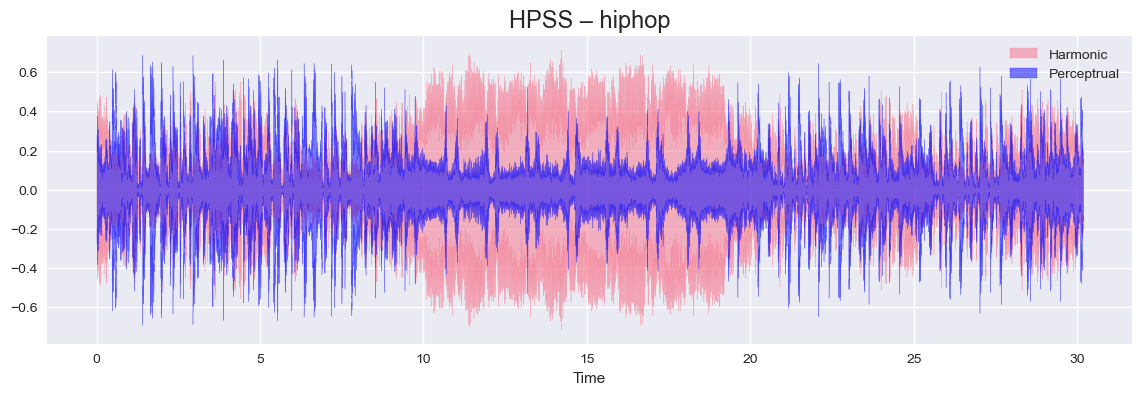

In [9]:
def show_hpss(y, sr, genre):
    harm, perc = librosa.effects.hpss(y)
    
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(harm, sr = sr, alpha=0.5, label = 'Harmonic')
    librosa.display.waveshow(perc, sr = sr, color = 'b', alpha=0.5, label = 'Perceptrual')
    plt.title(f"HPSS – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_hpss(sample_y, sample_sr, 'hiphop')

## Tempo BMP
Estimación global de BPM y localización de golpes.

Confirma si el género se mueve en rangos típicos (ej.: jazz ≈ 120-180 BPM).

Tempo estimado: 95.7 BPM


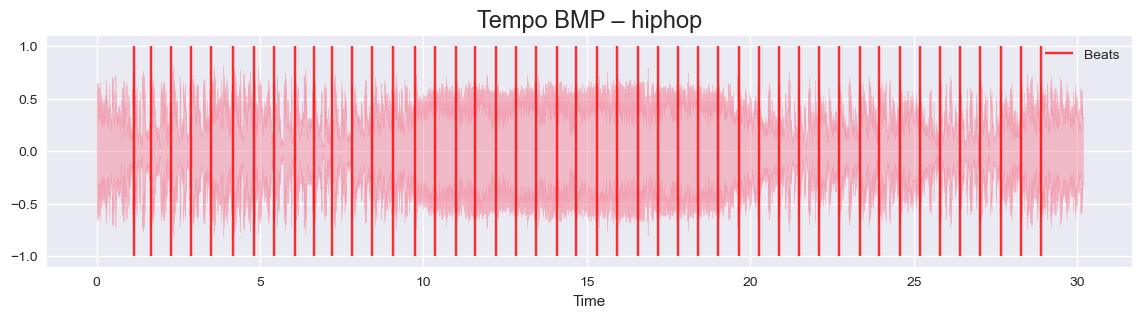

In [10]:
def show_bpm(y, sr, genre):
    # Estimación de tempo (BPM) y beats
    tempo, beats = librosa.beat.beat_track(y = y, sr = sr, units = 'time')
    
    # Si el tempo es un array, lo convertimos a escalar
    if isinstance(tempo, np.ndarray):
        tempo = float(tempo.squeeze())
    
    print(f"Tempo estimado: {tempo:.1f} BPM")
    
    # Visualización del audio y los beats detectados
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.vlines(beats, -1, 1, color = 'red', alpha = 0.8, label = 'Beats')
    plt.title(f"Tempo BMP – {genre}", fontsize = 17)
    plt.xlabel("Time")
    plt.legend()
    plt.show()

show_bpm(sample_y, sample_sr, 'hiphop')

## Spectral Centroid
“Centro de masas” del espectro por frame (brillo percibido).

Indicador de nitidez/​brillantez: metal ≫ clásica, por ejemplo.

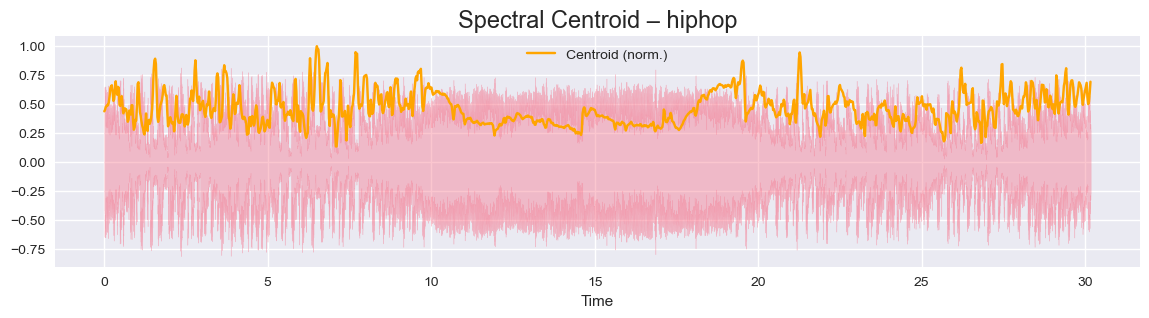

In [11]:
def show_spectral_centroid(y, sr, genre):
    centroid = librosa.feature.spectral_centroid(y = y, sr = sr, hop_length = 512)[0]
    centroid_norm = centroid / centroid.max()            # para escalar en la onda
    times = librosa.times_like(centroid, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.plot(times, centroid_norm, color = 'orange', label = 'Centroid (norm.)')
    plt.title(f"Spectral Centroid – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_spectral_centroid(sample_y, sample_sr, 'hiphop')

## Spectral Rolloff
Frecuencia por debajo de la cual se concentra un porcentaje (85-95%) de la energía.

Distingue señales con mucha energía en agudos (alta rolloff) de graves/​suaves.

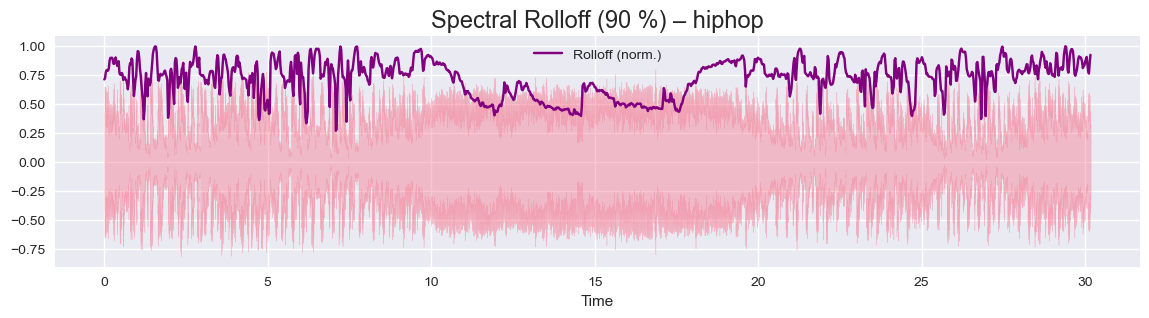

In [12]:
def show_spectral_rolloff(y, sr, genre):
    rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr, hop_length = 512, roll_percent = 0.90)[0]
    rolloff_norm = rolloff / rolloff.max()
    times = librosa.times_like(rolloff, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.plot(times, rolloff_norm, color = 'purple', label = 'Rolloff (norm.)')
    plt.title(f"Spectral Rolloff (90 %) – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_spectral_rolloff(sample_y, sample_sr, 'hiphop')

## MFCC (Mel-Frequency Cepstral Coefficients)
Resumen compacto de la envolvente espectral en escala Mel (timbre).

Muy usados en clasificación de género, identificación de instrumentos y voz.

Mean: -9.0288693e-10
Var: 1.0


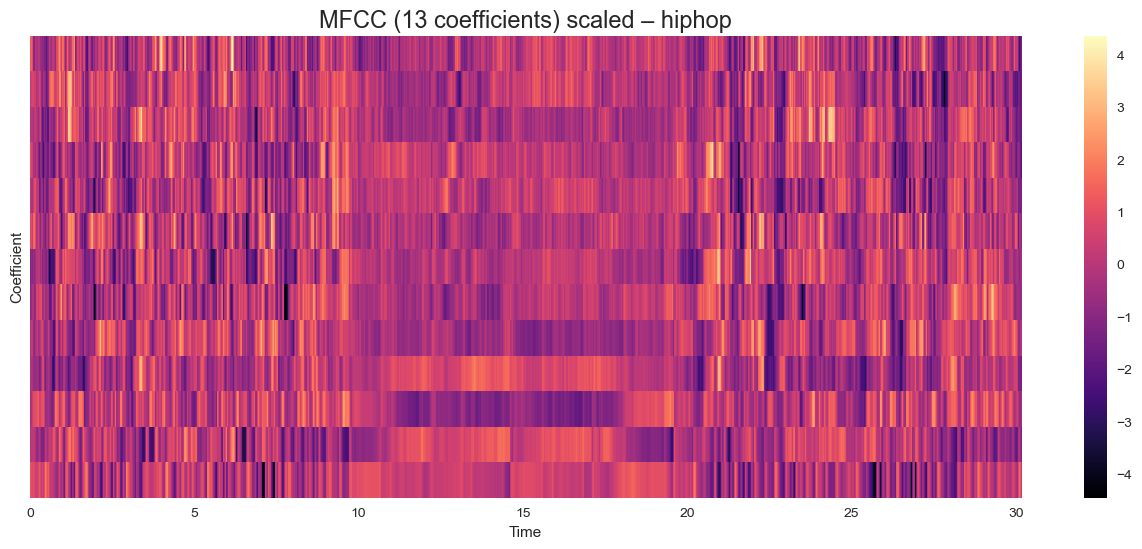

In [13]:
def show_mfcc(y, sr, genre):
    mfcc = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13, hop_length = 512)
    #plt.figure(figsize = (14, 4))
    #librosa.display.specshow(mfcc, sr = sr, hop_length = 512, x_axis = 'time', cmap = 'magma')
    #plt.colorbar()
    #plt.title(f"MFCC (13 coefficients) – {genre}", fontsize = 17)
    #plt.ylabel("Coeficiente")
    #plt.show()

    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    print('Mean:', mfcc.mean())
    print('Var:', mfcc.var())
    
    plt.figure(figsize = (16, 6))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap = 'magma')
    plt.colorbar()
    plt.title(f"MFCC (13 coefficients) scaled – {genre}", fontsize = 17)
    plt.ylabel("Coefficient")
    plt.show()

show_mfcc(sample_y, sample_sr, 'hiphop')

## Chroma Frequencies
Distribución de energía en las 12 clases de altura (C, C♯, D…).

Revela progresiones armónicas independientemente de la octava; útil para detectar tonalidad y acordes.

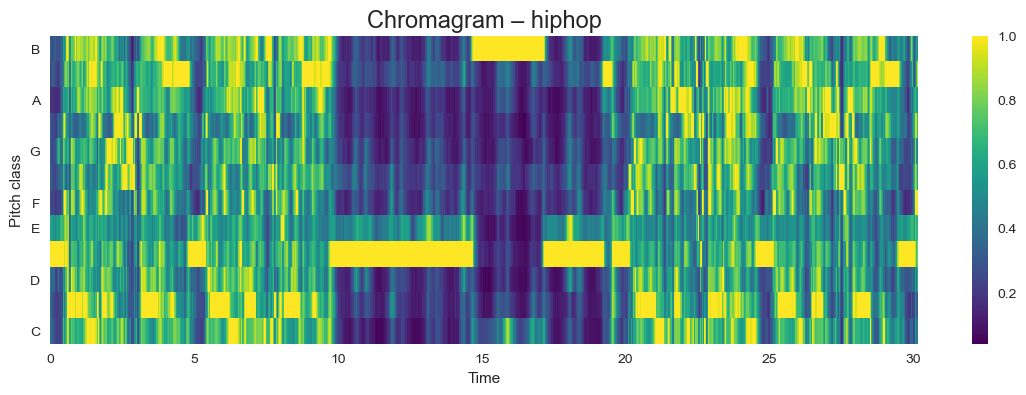

In [14]:
def show_chroma_freq(y, sr, genre):
    chroma = librosa.feature.chroma_cqt(y = y, sr = sr, hop_length = 512)
    plt.figure(figsize = (14, 4))
    librosa.display.specshow(chroma, x_axis = 'time', y_axis = 'chroma', cmap = 'viridis', hop_length = 512)
    plt.colorbar()
    plt.title(f"Chromagram – {genre}", fontsize = 17)
    plt.show()

show_chroma_freq(sample_y, sample_sr, 'hiphop')

In [15]:
def show_genre_graphs(genre):
    audio_path = track_by_gender(os.path.join(data_path, genre))
    y, sr = librosa.load(audio_path, sr = None)
    dur = librosa.get_duration(y = y, sr = sr)
    
    print(f"Género: {genre} | Archivo: {os.path.basename(audio_path)}")
    print(f"Frecuencia de muestreo: {sr} Hz | Duración: {dur:.1f} s")

    #show_soundwave(y, sr, genre)

    show_mfcc(y, sr, genre)

    show_chroma_freq(y, sr, genre)

    #show_stft(y, genre)

    #show_mel_spectogram(y, sr, genre)

    #show_hpss(y, sr, genre)

    #show_bpm(y, sr, genre)

    show_spectral_centroid(y, sr, genre)

    show_spectral_rolloff(y, sr, genre)

    show_zcr(y, sr, genre)

## Análisis de Características de Audio para Clustering No Supervisado en el Dataset GTZAN
Para el agrupamiento automático de canciones en el dataset GTZAN mediante aprendizaje no supervisado, la elección de características de audio es fundamental para el éxito del algoritmo. A continuación, analizo las características más relevantes y proporciono argumentos sobre su idoneidad para clustering musical.

### Características Más Relevantes
1. __MFCC (Mel-Frequency Cepstral Coefficients)__

Los MFCC son altamente recomendables para el clustering musical por varias razones:

Ventajas:
* Percepción humana: Los MFCC están diseñados para aproximar la percepción auditiva humana, utilizando la escala Mel que es lineal por debajo de 1000 Hz y logarítmica después
* Robustez: Son resistentes a variaciones en tono, acento y ruido, lo que los hace ideales para clustering de géneros musicales diversos
* Información espectral compacta: Capturan eficientemente la envolvente espectral y características timbrales
* Rendimiento probado: Han demostrado consistentemente alta precisión en tareas de clasificación musical, especialmente para instrumentos como bajo, flauta, órgano y voces

Aplicación en clustering:

Los MFCC se extraen típicamente usando ventanas de 25-30ms con desplazamientos de 5-10ms, y se utilizan los primeros 12-13 coeficientes. Para clustering, se suelen calcular estadísticas como la media y varianza de estos coeficientes por segmento.

2. __Chroma Features__

Las características de chroma son muy valiosas para el clustering musical:

Ventajas:
* Contenido armónico: Capturan información sobre clases de tono y contenido melódico/armónico
* Invariancia a octavas: Representan la información tonal independientemente de la octava específica
* Clustering por tonalidad: Permiten agrupar música por tonalidades musicales de manera no supervisada
* 
Aplicación específica:

Son especialmente útiles para clustering de música clásica y géneros donde la armonía es fundamental.

3. __Características Espectrales Complementarias__

__Spectral Centroid:__
* Mide el "brillo" o centro de gravedad espectral de la señal
* Útil para distinguir entre géneros con diferentes características timbrales

__Spectral Rolloff:__
* Describe la forma espectral, indicando la frecuencia por debajo de la cual se concentra el 85-95% de la energía
* Efectivo para discriminar géneros con diferentes distribuciones de energía en frecuencia

__Zero Crossing Rate (ZCR):__
* Tasa de cambios de signo en la señal de audio
* Especialmente útil para clasificar sonidos percusivos y distinguir entre voz y música

Género: classical | Archivo: classical.00000.wav
Frecuencia de muestreo: 22050 Hz | Duración: 30.0 s
Mean: 4.5388748e-10
Var: 1.0


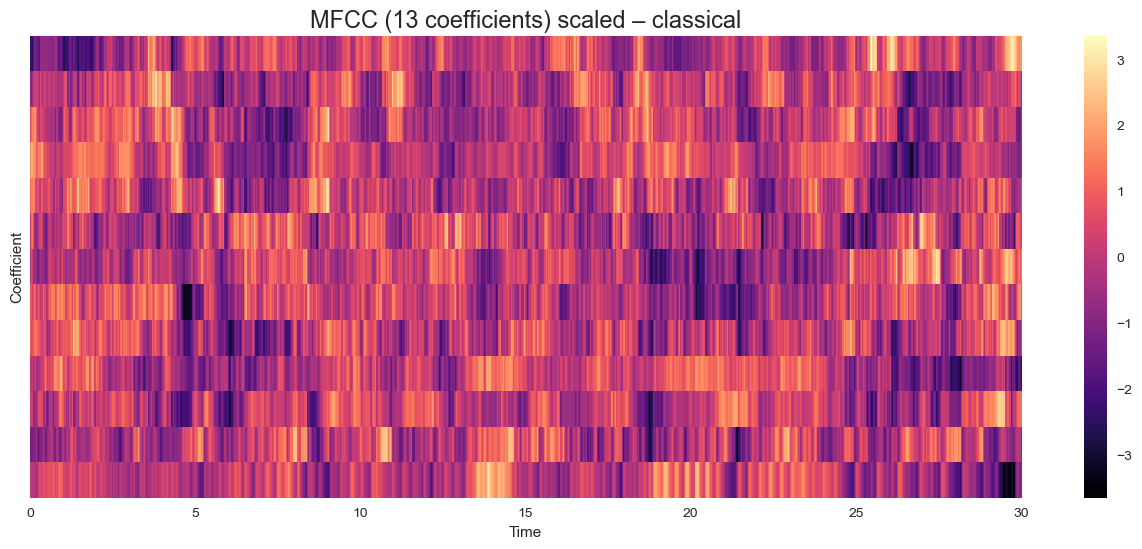

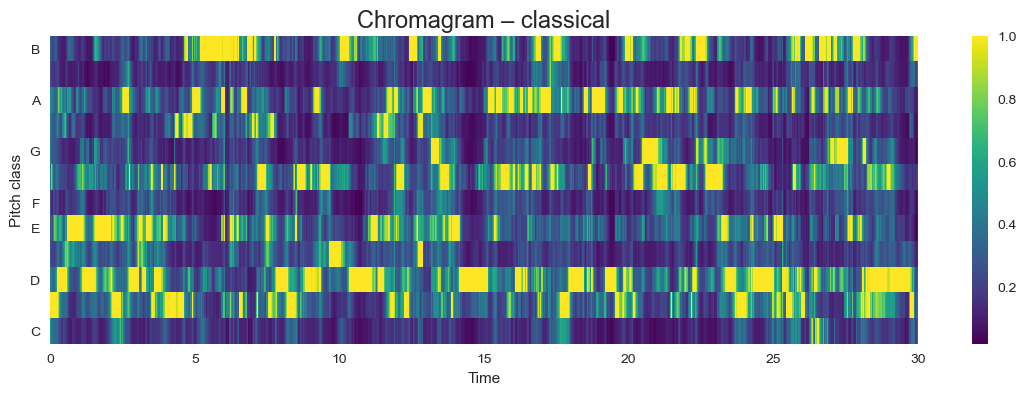

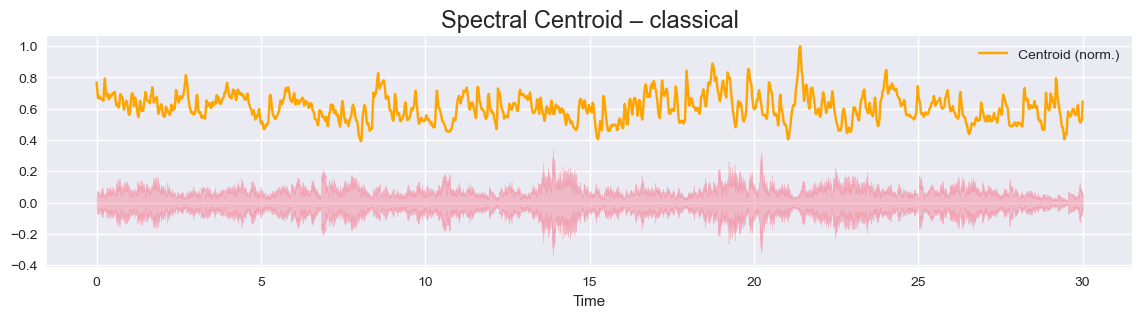

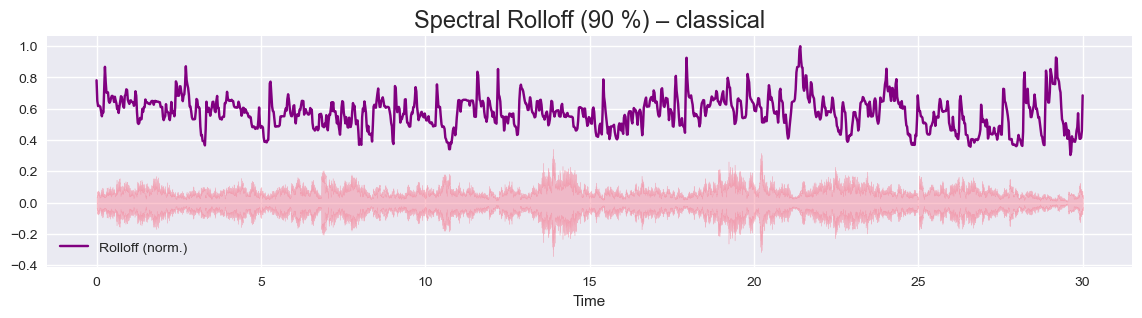

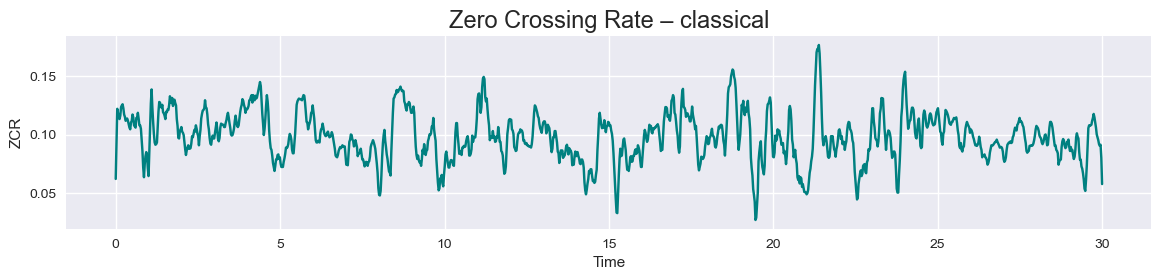

Género: hiphop | Archivo: hiphop.00000.wav
Frecuencia de muestreo: 22050 Hz | Duración: 30.0 s
Mean: 1.1347187e-09
Var: 1.0


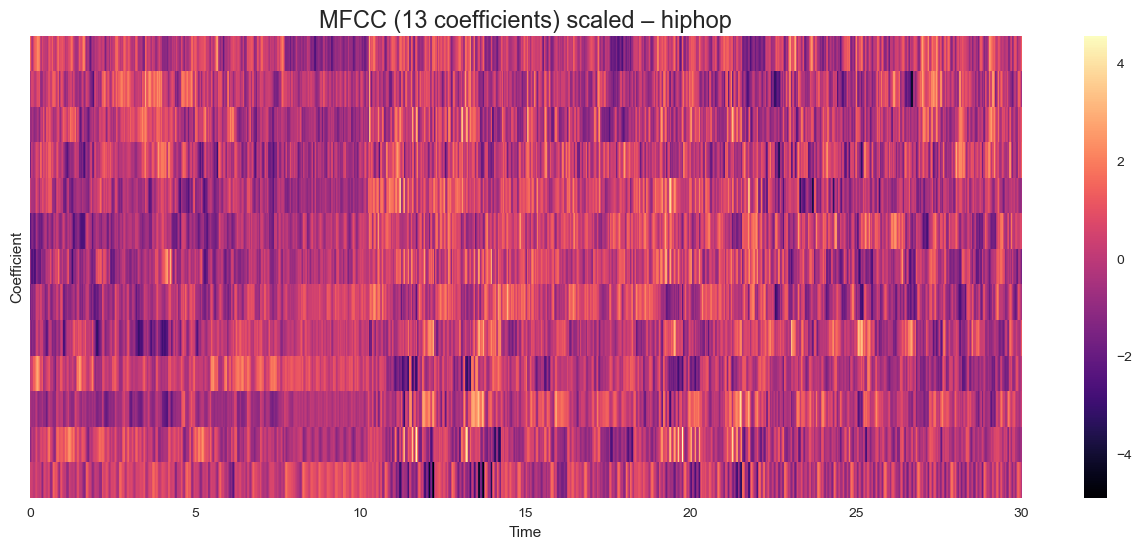

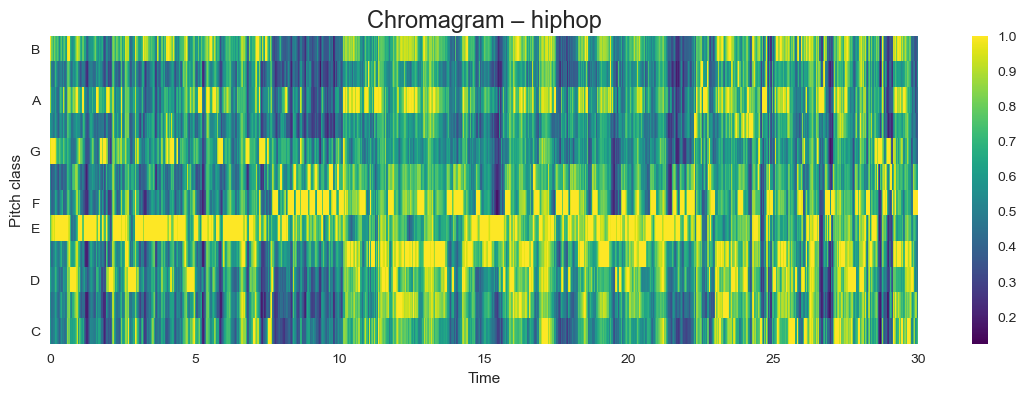

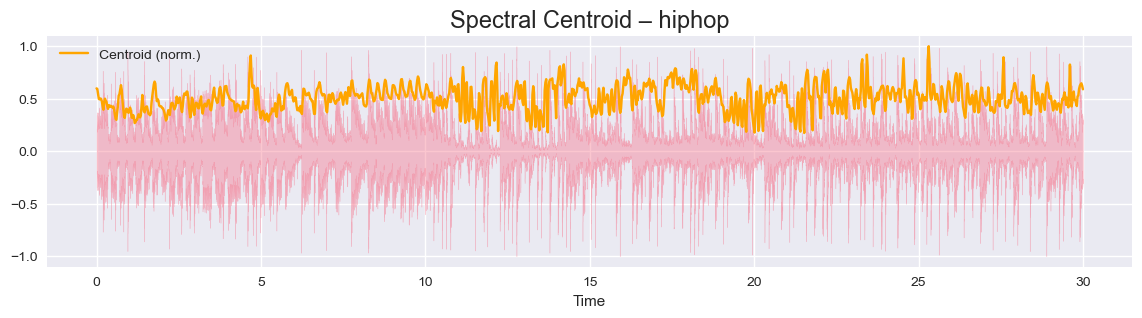

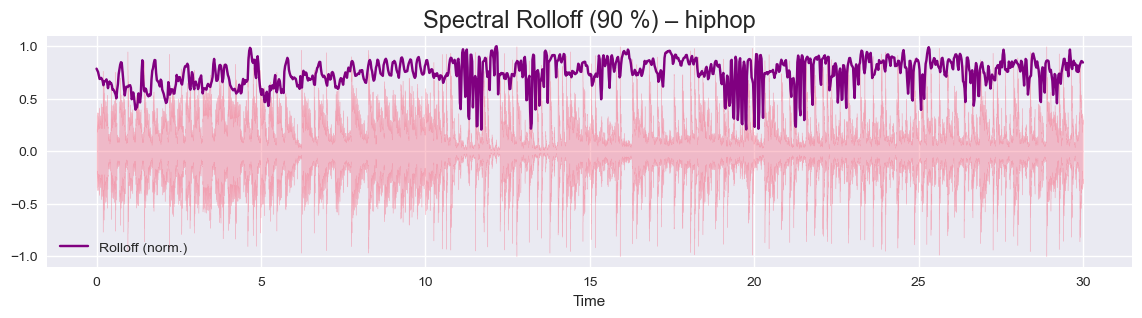

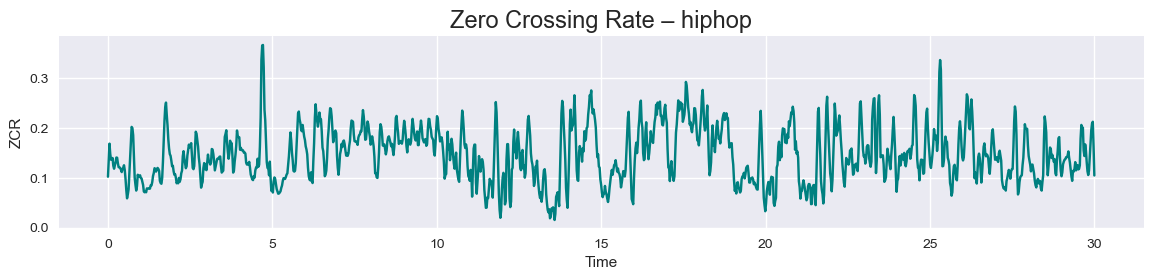

Género: jazz | Archivo: jazz.00000.wav
Frecuencia de muestreo: 22050 Hz | Duración: 30.0 s
Mean: -2.2694373e-09
Var: 1.0


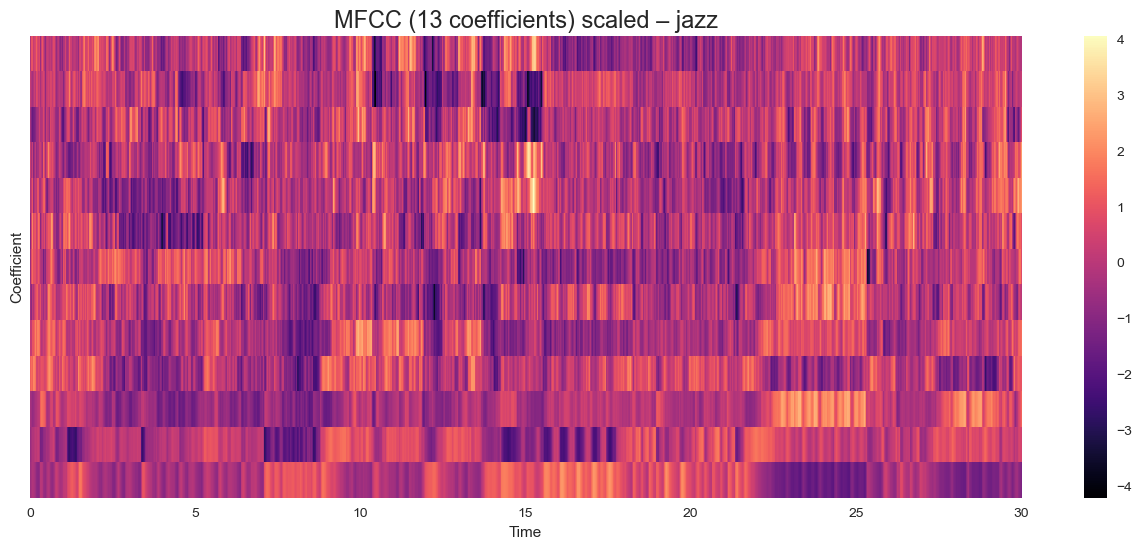

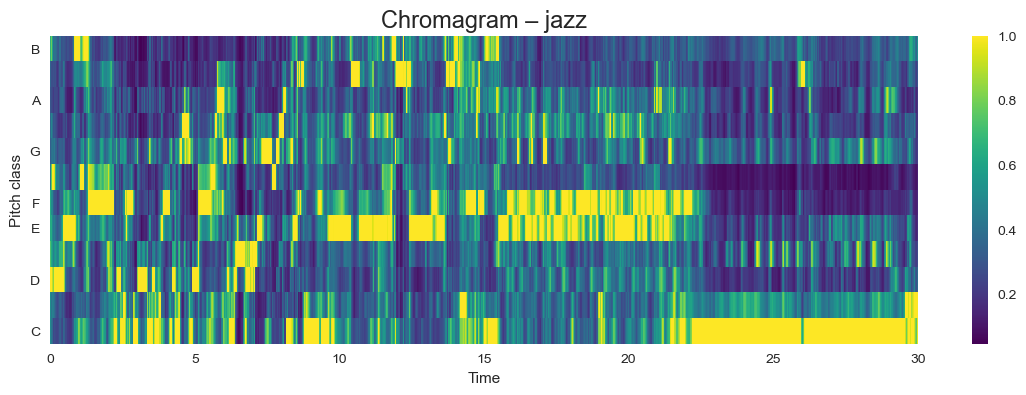

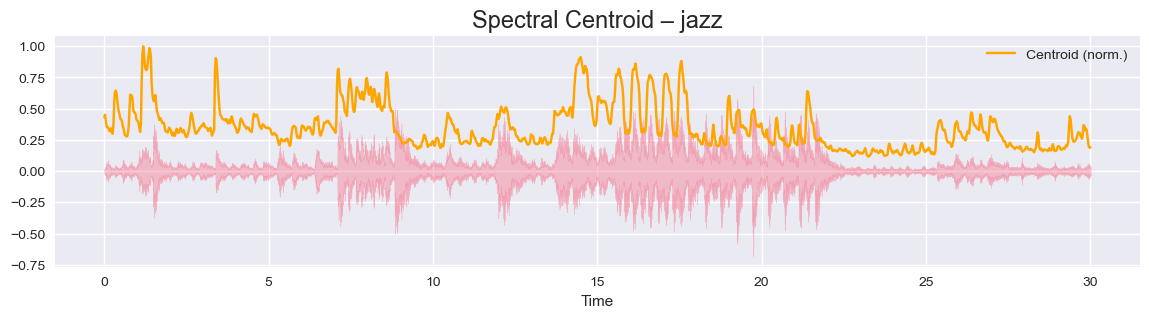

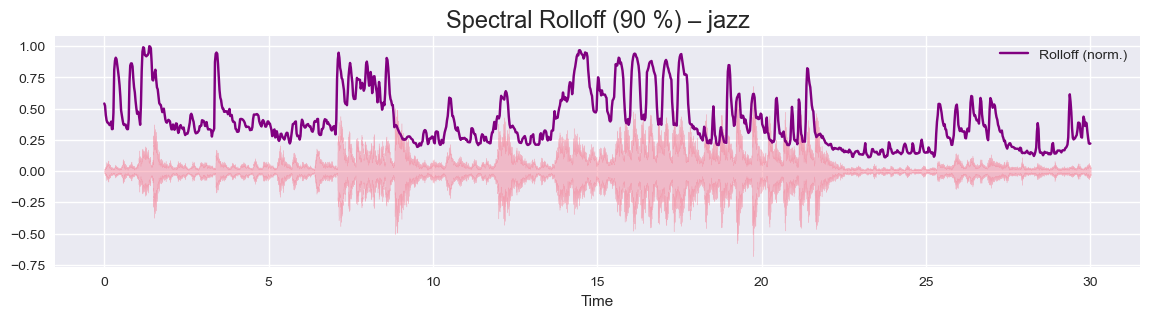

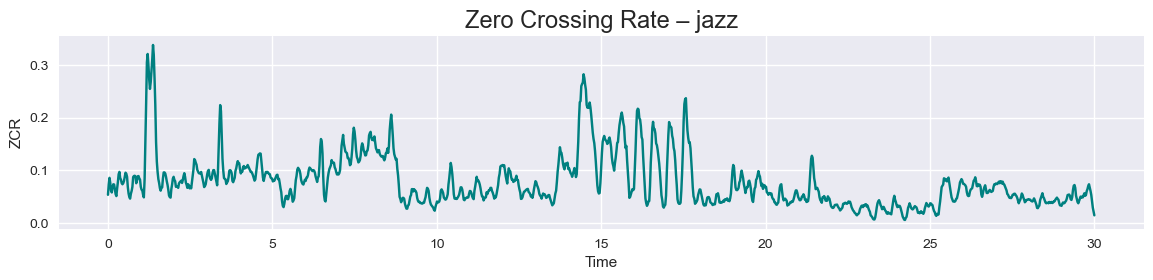

Género: metal | Archivo: metal.00000.wav
Frecuencia de muestreo: 22050 Hz | Duración: 30.0 s
Mean: 3.1772123e-09
Var: 1.0


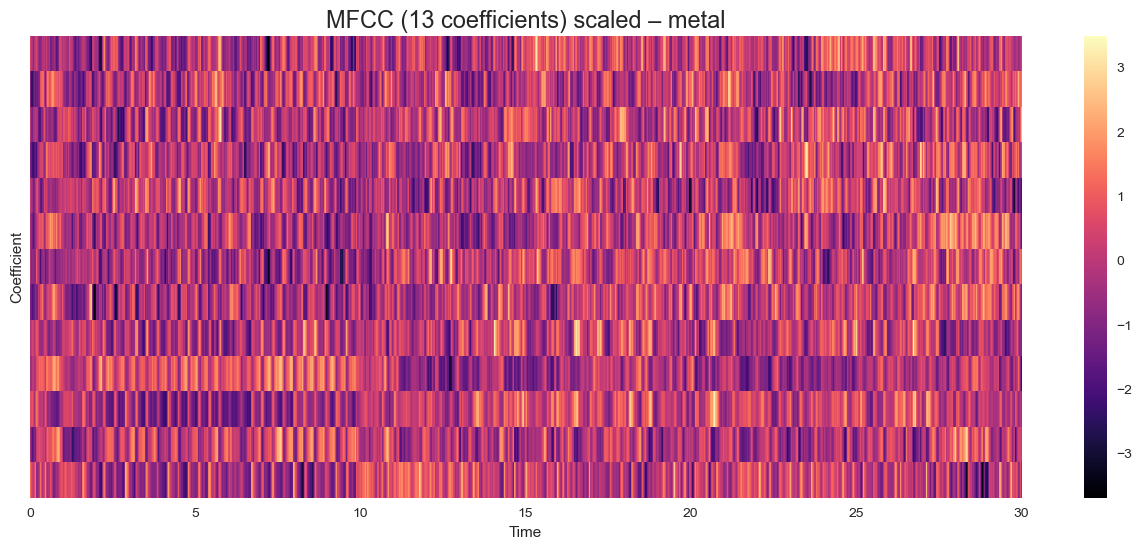

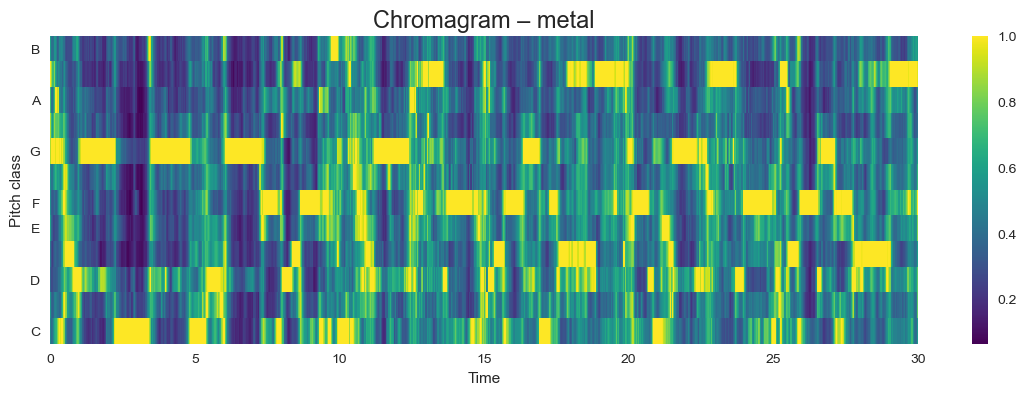

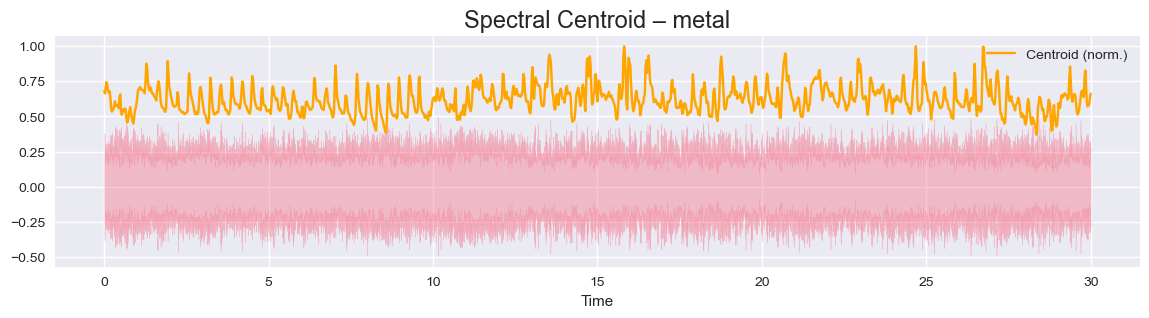

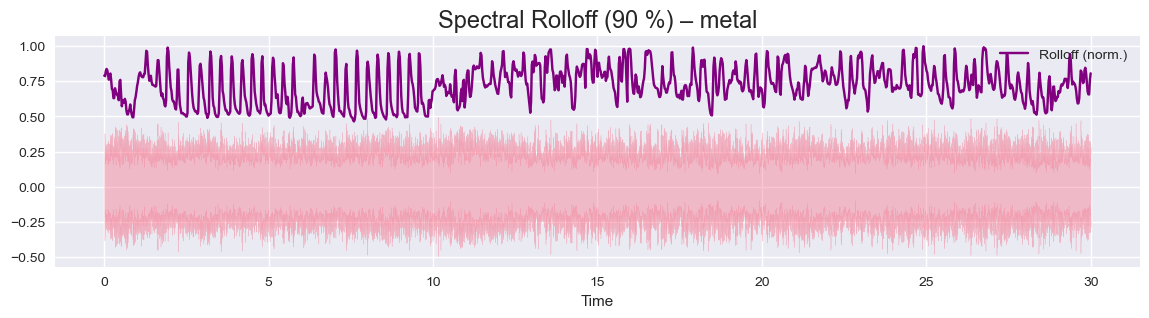

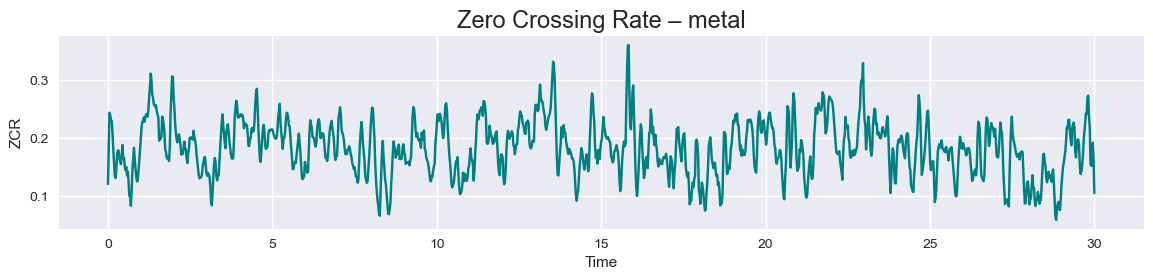

In [16]:
genres = ['classical', 'hiphop', 'jazz', 'metal']

for genre in genres:
    show_genre_graphs(genre)

In [17]:
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

def extract_audio_features(audio_path, sr=22050, hop_length=512):
    """
    Extrae características de audio de un archivo
    """
    # Cargar audio
    y, sr = librosa.load(audio_path, sr=sr)
    
    # MFCC (13 coeficientes)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)
    
    # Chroma features
    chroma = librosa.feature.chroma_cqt(y = y, sr = sr, hop_length = hop_length)
    
    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    return {
        'mfcc': mfcc,
        'chroma': chroma,
        'spectral_centroid': spectral_centroid,
        'spectral_rolloff': spectral_rolloff,
        'zcr': zero_crossing_rate
    }

def aggregate_features(features_dict):
    """
    Agrega características temporales usando estadísticas
    """
    aggregated = {}
    
    for feature_name, feature_values in features_dict.items():
        # Calcular estadísticas para cada característica
        stats = {
            'mean': np.mean(feature_values, axis=1),
            'std': np.std(feature_values, axis=1),
            'min': np.min(feature_values, axis=1),
            'max': np.max(feature_values, axis=1),
            'q25': np.percentile(feature_values, 25, axis=1),
            'q75': np.percentile(feature_values, 75, axis=1)
        }
        
        # Crear nombres de características
        for stat_name, stat_values in stats.items():
            for i, value in enumerate(stat_values):
                aggregated[f'{feature_name}_{stat_name}_{i}'] = value
    
    return aggregated

def build_dataset(audio_directory, output_path='audio_features.csv'):
    """
    Construye el dataset completo
    """
    all_features = []
    
    for root, dirs, files in os.walk(audio_directory):
        for file in files:
            if file.endswith('.wav'):
                filepath = os.path.join(root, file)
                
                try:
                    # Extraer características
                    features = extract_audio_features(filepath)
                    
                    # Agregar características
                    aggregated = aggregate_features(features)
                    
                    # Añadir metadatos
                    aggregated['filename'] = file
                    aggregated['genre'] = os.path.basename(root)  # Asume estructura de carpetas por género
                    
                    all_features.append(aggregated)
                    
                except Exception as e:
                    print(f"Error procesando {file}: {e}")
    
    # Crear DataFrame
    df = pd.DataFrame(all_features)
    
    # Guardar dataset
    df.to_csv(output_path, index=False)
    
    return df

In [18]:
def preprocess_dataset(df, feature_columns):
    """
    Preprocesa el dataset para clustering
    """
    # Separar características numéricas
    X = df[feature_columns].copy()
    
    # Manejar valores NaN
    X = X.fillna(X.mean())
    
    # Normalización Z-score (media=0, std=1)
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Crear DataFrame normalizado
    X_normalized_df = pd.DataFrame(X_normalized, columns=feature_columns)
    
    return X_normalized_df, scaler

# Uso
df = build_dataset(f'{general_path}/genres_original')

# Obtener columnas de características (excluir metadatos)
feature_columns = [col for col in df.columns if col not in ['filename', 'genre']]

# Normalizar
X_normalized, scaler = preprocess_dataset(df, feature_columns)

Error procesando jazz.00054.wav: 


In [19]:
X_normalized

mfcc_mean_0  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  mfcc_mean_4  \
0       0.308655     0.703778    -0.471893     0.363700    -0.426341   
1      -0.628595     0.780878     0.824257    -0.026329     0.332392   
2       0.536586     1.306353    -0.929421    -0.277299    -1.049431   
3      -0.549278     1.614351     0.672846    -0.567349     0.239143   
4      -0.157903     0.851907    -1.228998    -0.850471    -2.563074   
..           ...          ...          ...          ...          ...   
994    -0.090805     0.331255    -0.653081     1.363302    -0.521120   
995     0.021095     0.532452    -1.071245     0.768785    -0.592266   
996     0.194989     0.499782    -1.800982     0.991441    -1.009911   
997    -0.803318     0.770408    -0.037659     1.219181     0.947131   
998    -0.904774     0.777257    -0.627927     0.999326    -0.024674   

     mfcc_mean_5  mfcc_mean_6  mfcc_mean_7  mfcc_mean_8  mfcc_mean_9  ...  \
0       0.336171    -0.861775     0.498278    -0.636702     0.407879  ...   
1       0.580966    -0.344343     1.265962    -0.374616     0.524840  ...   
2       0.938694    -0.858280     0.144077    -0.576818     0.249607  ...   
3      -0.034652     0.030778    -0.080333     0.753983     0.050495  ...   
4      -0.320371    -1.832645    -0.920927    -0.579018    -0.822760  ...   
..           ...          ...          ...          ...          ...  ...   
994     0.429663    -1.142292     0.760054    -1.836634     0.967013  ...   
995     0.696344    -1.326315     0.954322    -1.823360     0.385387  ...   
996     0.600549    -0.732793     0.955908    -1.373077     0.301123  ...   
997     0.506937    -0.515599     0.520408    -0.149650     0.639433  ...   
998     0.846333    -0.196651     0.455290    -0.698129     1.132004  ...   

     spectral_rolloff_min_0  spectral_rolloff_max_0  spectral_rolloff_q25_0  \
0                  0.253767               -0.273928               -0.361325   
1                 -1.047071               -0.016970               -0.876508   
2                 -0.953485               -0.906922               -0.814686   
3                 -1.000278               -0.292730               -1.522205   
4                 -0.335821               -0.599826               -0.704780   
..                      ...                     ...                     ...   
994                0.309919               -0.123514               -0.107167   
995                0.010445               -0.418075               -0.114037   
996                0.469014               -0.349135               -0.114037   
997               -0.906692               -0.317799               -0.828424   
998               -1.056429               -0.298997               -0.752864   

     spectral_rolloff_q75_0  zcr_mean_0  zcr_std_0  zcr_min_0  zcr_max_0  \
0                 -0.605831   -0.492940  -0.926910   0.853942  -0.746120   
1                 -0.324225   -1.138949  -0.484800  -0.850684  -0.255361   
2                 -1.025245   -0.654498  -0.754517  -0.447772   0.454169   
3                 -1.528541   -1.682714  -1.231516  -0.850684  -1.337395   
4                 -0.533932   -0.052403  -0.221768   1.256853   0.001844   
..                      ...         ...        ...        ...        ...   
994               -0.312242   -0.345040  -0.567020   0.141098  -0.284925   
995               -0.360175   -0.143218  -0.851740  -0.509759  -1.032888   
996               -0.623806    0.434694  -0.350441   0.420037  -0.311532   
997               -1.067186   -1.313949  -0.896016  -0.695718  -1.041757   
998               -0.701697   -0.654173  -0.119630  -0.788698  -0.778640   

     zcr_q25_0  zcr_q75_0  
0    -0.157478  -0.604501  
1    -1.083172  -1.133333  
2    -0.307222  -0.767958  
3    -1.505179  -1.575628  
4     0.005880  -0.094900  
..         ...        ...  
994  -0.130252  -0.412199  
995   0.305369  -0.200666  
996   0.713764   0.308935  
997  -1.178464  -1.248714  
998  -0.824522  -0.566041  

[999 rows x 168 

In [20]:
feature_columns = [col for col in df.columns if col not in ['filename', 'genre']]
X_normalized, scaler = preprocess_dataset(df, feature_columns)

# NUEVO: Encontrar número óptimo de clusters
def find_optimal_clusters(X, max_clusters=15):
    print("1. Aplicando PCA para reducir dimensionalidad...")
    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X)
    
    print(f"   - Dimensiones originales: {X.shape}")
    print(f"   - Dimensiones después de PCA: {X_pca.shape}")
    
    # Evaluar diferentes números de clusters
    k_range = range(2, max_clusters + 1)
    silhouette_scores = []
    db_scores = []
    inertias = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_pca)
        
        sil_score = silhouette_score(X_pca, labels)
        db_score = davies_bouldin_score(X_pca, labels)
        
        silhouette_scores.append(sil_score)
        db_scores.append(db_score)
        inertias.append(kmeans.inertia_)
        
        print(f"   k={k}: Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")
    
    # Encontrar óptimos
    best_k_silhouette = k_range[np.argmax(silhouette_scores)]
    best_k_db = k_range[np.argmin(db_scores)]
    
    return {
        'X_pca': X_pca,
        'pca': pca,
        'best_k_silhouette': best_k_silhouette,
        'best_k_db': best_k_db,
        'silhouette_scores': silhouette_scores,
        'db_scores': db_scores,
        'inertias': inertias
    }

# Ejecutar análisis
results = find_optimal_clusters(X_normalized)

1. Aplicando PCA para reducir dimensionalidad...
   - Dimensiones originales: (999, 168)
   - Dimensiones después de PCA: (999, 54)
   k=2: Silhouette=0.164, Davies-Bouldin=1.945
   k=3: Silhouette=0.187, Davies-Bouldin=1.775
   k=4: Silhouette=0.162, Davies-Bouldin=2.219
   k=5: Silhouette=0.132, Davies-Bouldin=2.313
   k=6: Silhouette=0.107, Davies-Bouldin=2.502
   k=7: Silhouette=0.097, Davies-Bouldin=2.424
   k=8: Silhouette=0.097, Davies-Bouldin=2.334
   k=9: Silhouette=0.098, Davies-Bouldin=2.305
   k=10: Silhouette=0.088, Davies-Bouldin=2.348
   k=11: Silhouette=0.076, Davies-Bouldin=2.540
   k=12: Silhouette=0.079, Davies-Bouldin=2.470
   k=13: Silhouette=0.074, Davies-Bouldin=2.467
   k=14: Silhouette=0.075, Davies-Bouldin=2.478
   k=15: Silhouette=0.080, Davies-Bouldin=2.389


In [21]:
# Continuar desde donde terminaste
feature_columns = [col for col in df.columns if col not in ['filename', 'genre']]
X_normalized, scaler = preprocess_dataset(df, feature_columns)

# NUEVO: Encontrar número óptimo de clusters
def find_optimal_clusters(X, max_clusters=15):
    print("1. Aplicando PCA para reducir dimensionalidad...")
    pca = PCA(n_components=0.8, random_state=42)
    X_pca = pca.fit_transform(X)
    
    print(f"   - Dimensiones originales: {X.shape}")
    print(f"   - Dimensiones después de PCA: {X_pca.shape}")
    
    # Evaluar diferentes números de clusters
    k_range = range(2, max_clusters + 1)
    silhouette_scores = []
    db_scores = []
    inertias = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_pca)
        
        sil_score = silhouette_score(X_pca, labels)
        db_score = davies_bouldin_score(X_pca, labels)
        
        silhouette_scores.append(sil_score)
        db_scores.append(db_score)
        inertias.append(kmeans.inertia_)
        
        print(f"   k={k}: Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")
    
    # Encontrar óptimos
    best_k_silhouette = k_range[np.argmax(silhouette_scores)]
    best_k_db = k_range[np.argmin(db_scores)]
    
    return {
        'X_pca': X_pca,
        'pca': pca,
        'best_k_silhouette': best_k_silhouette,
        'best_k_db': best_k_db,
        'silhouette_scores': silhouette_scores,
        'db_scores': db_scores,
        'inertias': inertias
    }

# Ejecutar análisis
results = find_optimal_clusters(X_normalized)

1. Aplicando PCA para reducir dimensionalidad...
   - Dimensiones originales: (999, 168)
   - Dimensiones después de PCA: (999, 19)
   k=2: Silhouette=0.194, Davies-Bouldin=1.751
   k=3: Silhouette=0.223, Davies-Bouldin=1.572
   k=4: Silhouette=0.196, Davies-Bouldin=1.964
   k=5: Silhouette=0.161, Davies-Bouldin=2.041
   k=6: Silhouette=0.135, Davies-Bouldin=2.163
   k=7: Silhouette=0.126, Davies-Bouldin=2.102
   k=8: Silhouette=0.126, Davies-Bouldin=2.013
   k=9: Silhouette=0.117, Davies-Bouldin=2.122
   k=10: Silhouette=0.108, Davies-Bouldin=2.124
   k=11: Silhouette=0.111, Davies-Bouldin=2.057
   k=12: Silhouette=0.106, Davies-Bouldin=2.120
   k=13: Silhouette=0.112, Davies-Bouldin=2.030
   k=14: Silhouette=0.108, Davies-Bouldin=2.051
   k=15: Silhouette=0.110, Davies-Bouldin=2.013


In [22]:
def perform_final_clustering(X_pca, optimal_k, df_meta):
    print(f"Realizando clustering final con k={optimal_k}...")
    
    # K-Means final
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=50)
    cluster_labels = kmeans_final.fit_predict(X_pca)
    
    # Métricas finales
    sil_score = silhouette_score(X_pca, cluster_labels)
    db_score = davies_bouldin_score(X_pca, cluster_labels)
    
    print(f"Métricas finales:")
    print(f"  - Silhouette Score: {sil_score:.3f}")
    print(f"  - Davies-Bouldin Index: {db_score:.3f}")
    
    # Crear DataFrame con resultados
    results_df = df_meta.copy()
    results_df['cluster'] = cluster_labels
    
    # Analizar distribución de clusters
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    for cluster, count in cluster_counts.items():
        print(f"  Cluster {cluster}: {count} canciones ({count/len(cluster_labels)*100:.1f}%)")
    
    # Tabla de contingencia (si tienes géneros)
    if 'genre' in df_meta.columns:
        contingency_table = pd.crosstab(results_df['cluster'], results_df['genre'])
        print(contingency_table)
    
    return results_df, kmeans_final

# Usar k óptimo (elige basándose en las métricas)
optimal_k = results['best_k_silhouette']  # o best_k_db
final_results, kmeans_model = perform_final_clustering(
    results['X_pca'], 
    optimal_k, 
    df[['filename', 'genre']]
)


Realizando clustering final con k=3...
Métricas finales:
  - Silhouette Score: 0.223
  - Davies-Bouldin Index: 1.572
  Cluster 0: 356 canciones (35.6%)
  Cluster 1: 321 canciones (32.1%)
  Cluster 2: 322 canciones (32.2%)
genre    blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
cluster                                                                       
0           54         99       62      3       2    73      2   11      29   
1            0          1       22     45      56    17      3   89      56   
2           46          0       16     52      42     9     95    0      15   

genre    rock  
cluster        
0          21  
1          32  
2          47  


Error procesando jazz.00054.wav: 
=== COMPARACIÓN DE ALGORITMOS DE CLUSTERING ===

Aplicando PCA para reducir dimensionalidad...
Dimensiones después de PCA: (999, 26)

1. K-MEANS

2. DBSCAN
Buscando parámetros óptimos para DBSCAN...


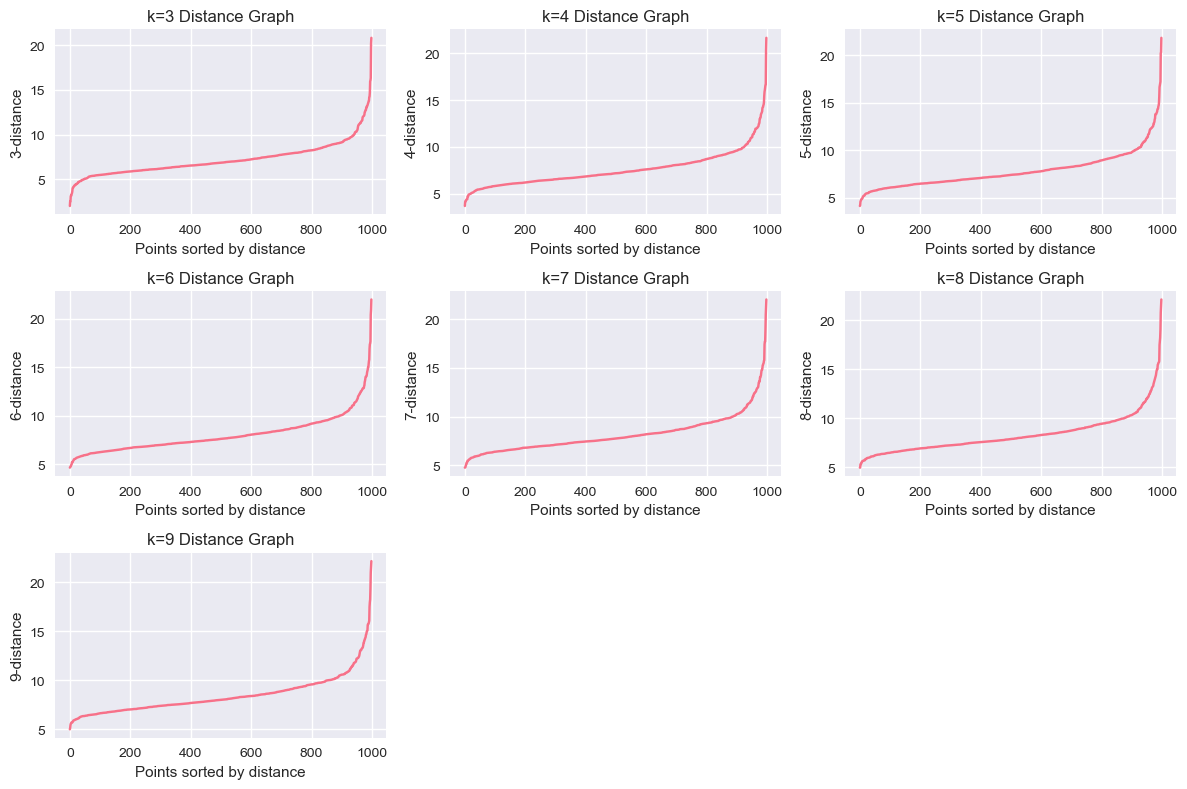

Valores sugeridos de eps: [10.972259845546036, 9.58149519788827, 9.089919928567326]

Evaluando DBSCAN con diferentes parámetros...
eps=9.090, min_samples=3: clusters=2, noise=70 (7.0%), silhouette=0.202

Mejores parámetros DBSCAN: {'eps': 9.089919928567326, 'min_samples': 3}
Mejor silhouette score: 0.202

3. HDBSCAN

Evaluando HDBSCAN con diferentes parámetros...
min_cluster_size=5: clusters=2, noise=243 (24.3%), silhouette=0.079
min_cluster_size=10: clusters=2, noise=690 (69.1%), silhouette=-0.004
min_cluster_size=15: clusters=2, noise=718 (71.9%), silhouette=-0.020
min_cluster_size=20: clusters=2, noise=716 (71.7%), silhouette=-0.016

Mejores parámetros HDBSCAN: {'min_cluster_size': 5}
Mejor silhouette score: 0.079

4. CLUSTERING JERÁRQUICO

Evaluando clustering jerárquico...


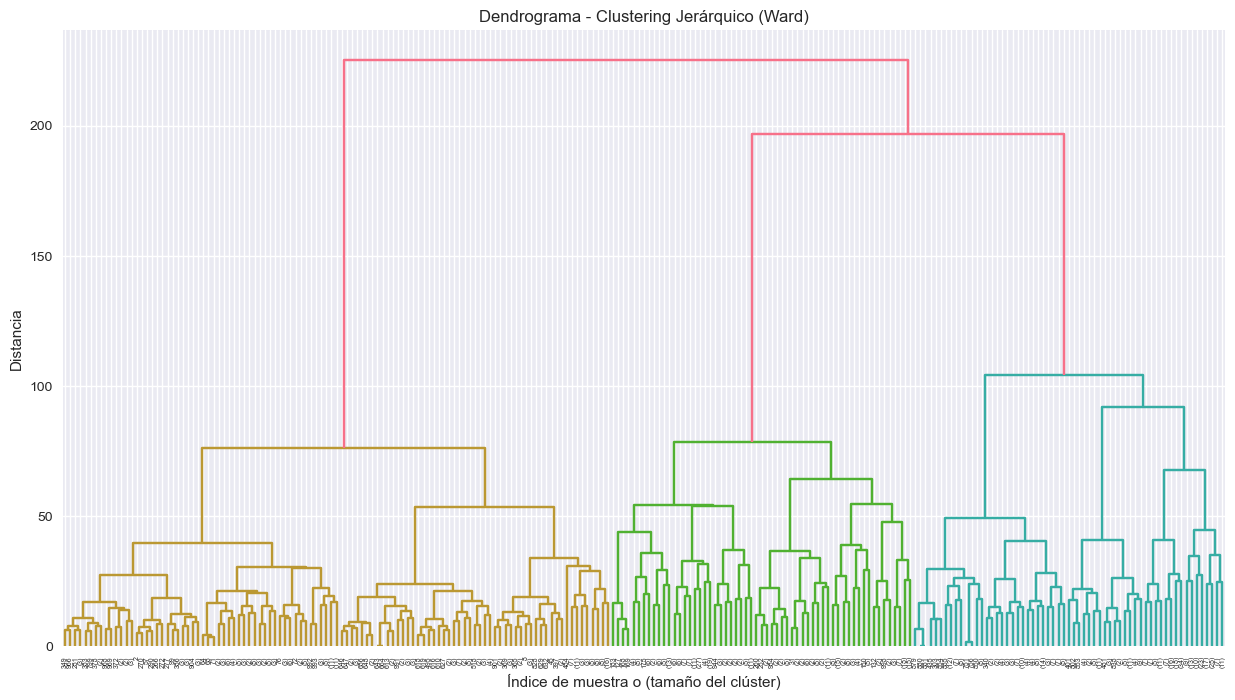

n_clusters=2: silhouette=0.165, davies_bouldin=1.732
n_clusters=3: silhouette=0.186, davies_bouldin=1.804
n_clusters=4: silhouette=0.141, davies_bouldin=2.044
n_clusters=5: silhouette=0.127, davies_bouldin=1.983
n_clusters=6: silhouette=0.123, davies_bouldin=2.420
n_clusters=7: silhouette=0.087, davies_bouldin=2.507
n_clusters=8: silhouette=0.078, davies_bouldin=2.570
n_clusters=9: silhouette=0.081, davies_bouldin=2.469
n_clusters=10: silhouette=0.084, davies_bouldin=2.359
n_clusters=11: silhouette=0.084, davies_bouldin=2.453
n_clusters=12: silhouette=0.084, davies_bouldin=2.362
n_clusters=13: silhouette=0.079, davies_bouldin=2.336
n_clusters=14: silhouette=0.076, davies_bouldin=2.355
n_clusters=15: silhouette=0.073, davies_bouldin=2.264

Mejor número de clusters: 3
Mejor silhouette score: 0.186


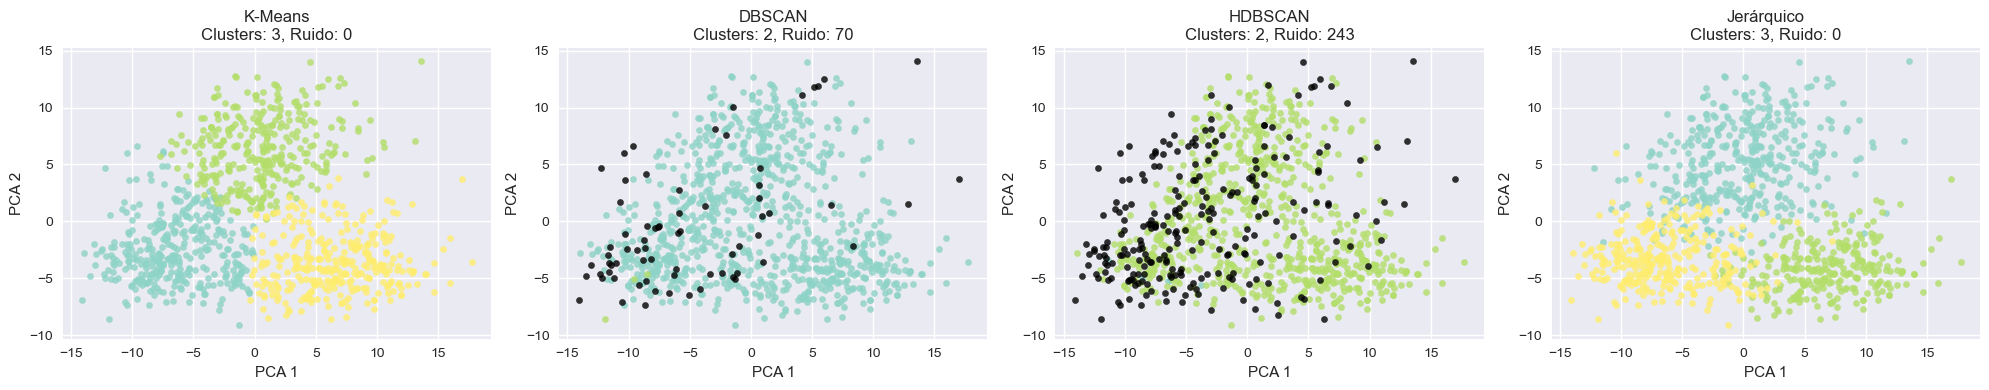


=== RESUMEN DE RESULTADOS ===
    Método  Clusters  Ruido  Silhouette  Davies-Bouldin
   K-Means         3      0    0.210029        1.640525
    DBSCAN         2     70    0.201889        3.046003
   HDBSCAN         2    243    0.079064        3.305930
Jerárquico         3      0    0.186479        1.803522


In [23]:
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import hdbscan
import warnings
warnings.filterwarnings('ignore')

# Tu código existente permanece igual
# ... (funciones extract_audio_features, aggregate_features, build_dataset, preprocess_dataset) ...

# Función para encontrar parámetros óptimos de DBSCAN
def find_optimal_dbscan_params(X, k_range=range(3, 10)):
    """
    Encuentra parámetros óptimos para DBSCAN usando k-distance graph
    """
    print("Buscando parámetros óptimos para DBSCAN...")
    
    # Calcular k-distance para diferentes valores de k
    distances = []
    for k in k_range:
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(X)
        distances_k, indices = neighbors_fit.kneighbors(X)
        distances.append(np.sort(distances_k[:, k-1], axis=0))
    
    # Visualizar k-distance graphs
    plt.figure(figsize=(12, 8))
    for i, (k, dist) in enumerate(zip(k_range, distances)):
        plt.subplot(3, 3, i+1)
        plt.plot(dist)
        plt.title(f'k={k} Distance Graph')
        plt.xlabel('Points sorted by distance')
        plt.ylabel(f'{k}-distance')
    
    plt.tight_layout()
    plt.show()
    
    # Sugerir valores de eps basándose en k=4 (común para datos de audio)
    k_4_distances = distances[1] if len(distances) > 1 else distances[0]
    eps_suggestions = [
        np.percentile(k_4_distances, 95),
        np.percentile(k_4_distances, 90),
        np.percentile(k_4_distances, 85)
    ]
    
    print(f"Valores sugeridos de eps: {eps_suggestions}")
    return eps_suggestions

# Función para DBSCAN con evaluación
def perform_dbscan_clustering(X, eps_values=None, min_samples_values=[3, 5, 10]):
    """
    Ejecuta DBSCAN con diferentes parámetros y evalúa resultados
    """
    if eps_values is None:
        eps_values = find_optimal_dbscan_params(X)
    
    print("\nEvaluando DBSCAN con diferentes parámetros...")
    
    results = []
    best_score = -1
    best_params = None
    best_labels = None
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            if n_clusters > 1:  # Necesario para calcular silhouette
                silhouette = silhouette_score(X, labels)
                
                result = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': silhouette,
                    'labels': labels
                }
                results.append(result)
                
                print(f"eps={eps:.3f}, min_samples={min_samples}: "
                      f"clusters={n_clusters}, noise={n_noise} ({n_noise/len(labels)*100:.1f}%), "
                      f"silhouette={silhouette:.3f}")
                
                if silhouette > best_score:
                    best_score = silhouette
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    best_labels = labels
    
    print(f"\nMejores parámetros DBSCAN: {best_params}")
    print(f"Mejor silhouette score: {best_score:.3f}")
    
    return best_labels, best_params, results

# Función para HDBSCAN
def perform_hdbscan_clustering(X, min_cluster_sizes=[5, 10, 15, 20]):
    """
    Ejecuta HDBSCAN con diferentes parámetros
    """
    print("\nEvaluando HDBSCAN con diferentes parámetros...")
    
    results = []
    best_score = -1
    best_params = None
    best_labels = None
    
    for min_cluster_size in min_cluster_sizes:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        labels = clusterer.fit_predict(X)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:
            silhouette = silhouette_score(X, labels)
            
            result = {
                'min_cluster_size': min_cluster_size,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette,
                'labels': labels,
                'probabilities': clusterer.probabilities_
            }
            results.append(result)
            
            print(f"min_cluster_size={min_cluster_size}: "
                  f"clusters={n_clusters}, noise={n_noise} ({n_noise/len(labels)*100:.1f}%), "
                  f"silhouette={silhouette:.3f}")
            
            if silhouette > best_score:
                best_score = silhouette
                best_params = {'min_cluster_size': min_cluster_size}
                best_labels = labels
    
    print(f"\nMejores parámetros HDBSCAN: {best_params}")
    print(f"Mejor silhouette score: {best_score:.3f}")
    
    return best_labels, best_params, results

# Función para clustering jerárquico
def perform_hierarchical_clustering(X, n_clusters_range=range(2, 16)):
    """
    Ejecuta clustering jerárquico y genera dendrograma
    """
    print("\nEvaluando clustering jerárquico...")
    
    # Generar dendrograma
    plt.figure(figsize=(15, 8))
    
    # Calcular linkage
    Z = linkage(X, method='ward')
    
    # Crear dendrograma
    dendrogram(Z, truncate_mode='level', p=7, show_leaf_counts=True)
    plt.title('Dendrograma - Clustering Jerárquico (Ward)')
    plt.xlabel('Índice de muestra o (tamaño del clúster)')
    plt.ylabel('Distancia')
    plt.show()
    
    # Evaluar diferentes números de clusters
    results = []
    best_score = -1
    best_k = None
    best_labels = None
    
    for n_clusters in n_clusters_range:
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        labels = hierarchical.fit_predict(X)
        
        silhouette = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        
        result = {
            'n_clusters': n_clusters,
            'silhouette': silhouette,
            'davies_bouldin': db_score,
            'labels': labels
        }
        results.append(result)
        
        print(f"n_clusters={n_clusters}: silhouette={silhouette:.3f}, "
              f"davies_bouldin={db_score:.3f}")
        
        if silhouette > best_score:
            best_score = silhouette
            best_k = n_clusters
            best_labels = labels
    
    print(f"\nMejor número de clusters: {best_k}")
    print(f"Mejor silhouette score: {best_score:.3f}")
    
    return best_labels, best_k, results

# Función de visualización
def visualize_clustering_results(X, labels_dict, title_suffix=""):
    """
    Visualiza resultados de diferentes algoritmos de clustering
    """
    # Reducir a 2D para visualización
    pca_2d = PCA(n_components=2, random_state=42)
    X_2d = pca_2d.fit_transform(X)
    
    n_methods = len(labels_dict)
    fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 4))
    
    if n_methods == 1:
        axes = [axes]
    
    for i, (method_name, labels) in enumerate(labels_dict.items()):
        # Colores especiales para ruido (-1)
        unique_labels = set(labels)
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
        
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Ruido en negro
                col = [0, 0, 0, 1]
            
            class_member_mask = (labels == k)
            xy = X_2d[class_member_mask]
            
            axes[i].scatter(xy[:, 0], xy[:, 1], c=[col], s=20, alpha=0.8)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        axes[i].set_title(f'{method_name}\nClusters: {n_clusters}, Ruido: {n_noise}')
        axes[i].set_xlabel('PCA 1')
        axes[i].set_ylabel('PCA 2')
    
    plt.tight_layout()
    plt.show()

# Función principal para ejecutar todos los algoritmos
def compare_clustering_algorithms(X, df_meta):
    """
    Compara todos los algoritmos de clustering
    """
    print("=== COMPARACIÓN DE ALGORITMOS DE CLUSTERING ===\n")
    
    # Aplicar PCA si no se ha hecho antes
    if X.shape[1] > 50:
        print("Aplicando PCA para reducir dimensionalidad...")
        pca = PCA(n_components=0.85, random_state=42)
        X_pca = pca.fit_transform(X)
        print(f"Dimensiones después de PCA: {X_pca.shape}")
    else:
        X_pca = X
    
    # Ejecutar cada algoritmo
    results = {}
    
    # 1. K-Means (tu código existente)
    print("\n1. K-MEANS")
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
    kmeans_labels = kmeans.fit_predict(X_pca)
    results['K-Means'] = kmeans_labels
    
    # 2. DBSCAN
    print("\n2. DBSCAN")
    dbscan_labels, dbscan_params, dbscan_results = perform_dbscan_clustering(X_pca)
    results['DBSCAN'] = dbscan_labels
    
    # 3. HDBSCAN
    print("\n3. HDBSCAN")
    hdbscan_labels, hdbscan_params, hdbscan_results = perform_hdbscan_clustering(X_pca)
    results['HDBSCAN'] = hdbscan_labels
    
    # 4. Clustering Jerárquico
    print("\n4. CLUSTERING JERÁRQUICO")
    hierarchical_labels, hierarchical_k, hierarchical_results = perform_hierarchical_clustering(X_pca)
    results['Jerárquico'] = hierarchical_labels
    
    # Visualizar resultados
    visualize_clustering_results(X_pca, results)
    
    # Crear tabla resumen
    summary_data = []
    for method, labels in results.items():
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        if n_clusters > 1:
            silhouette = silhouette_score(X_pca, labels)
            db_score = davies_bouldin_score(X_pca, labels)
        else:
            silhouette = np.nan
            db_score = np.nan
        
        summary_data.append({
            'Método': method,
            'Clusters': n_clusters,
            'Ruido': n_noise,
            'Silhouette': silhouette,
            'Davies-Bouldin': db_score
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\n=== RESUMEN DE RESULTADOS ===")
    print(summary_df.to_string(index=False))
    
    return results, summary_df

# Ejecutar comparación completa
if __name__ == "__main__":
    # Tu código existente
    df = build_dataset(f'{general_path}/genres_original')
    feature_columns = [col for col in df.columns if col not in ['filename', 'genre']]
    X_normalized, scaler = preprocess_dataset(df, feature_columns)
    
    # Ejecutar comparación
    clustering_results, summary = compare_clustering_algorithms(X_normalized, df[['filename', 'genre']])


In [24]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

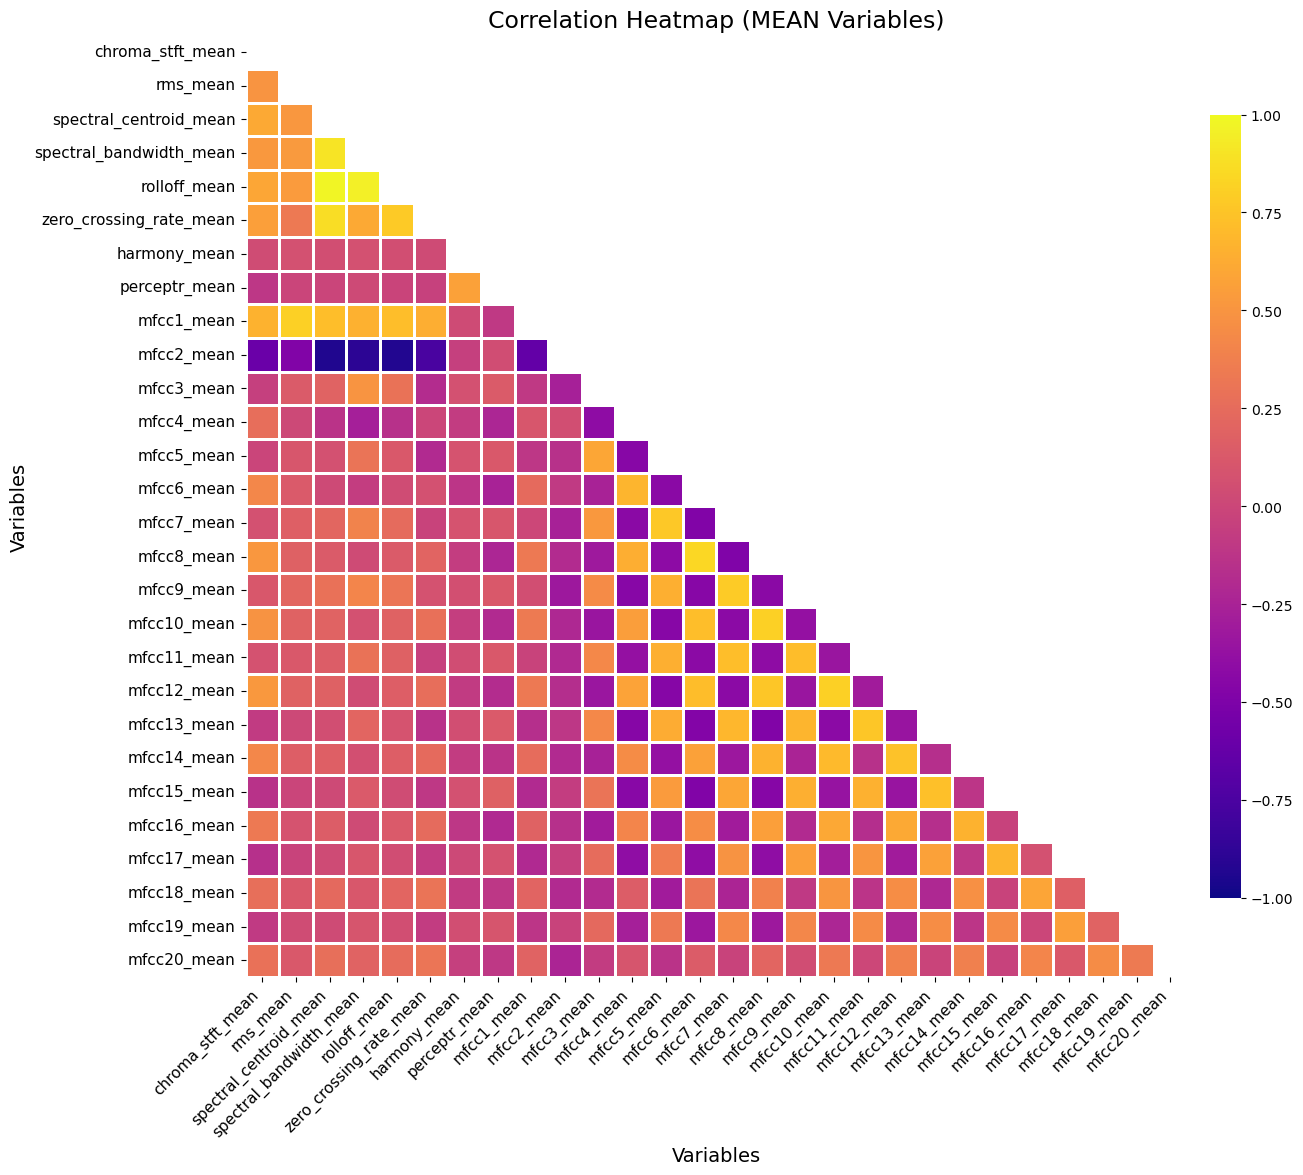

In [25]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.style.use('default')
f, ax = plt.subplots(figsize=(14, 12))

cmap = 'plasma'

heatmap = sns.heatmap(corr, 
                     mask=mask, 
                     cmap=cmap, 
                     vmin=-1, vmax=1,
                     center=0,
                     square=True, 
                     linewidths=0.8,
                     linecolor='white',
                     cbar_kws={"shrink": 0.8, "aspect": 25, "pad": 0.02},
                     annot_kws={'size': 11, 'weight': 'bold'})

plt.title('Correlation Heatmap (MEAN Variables)', fontsize=17)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variables', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

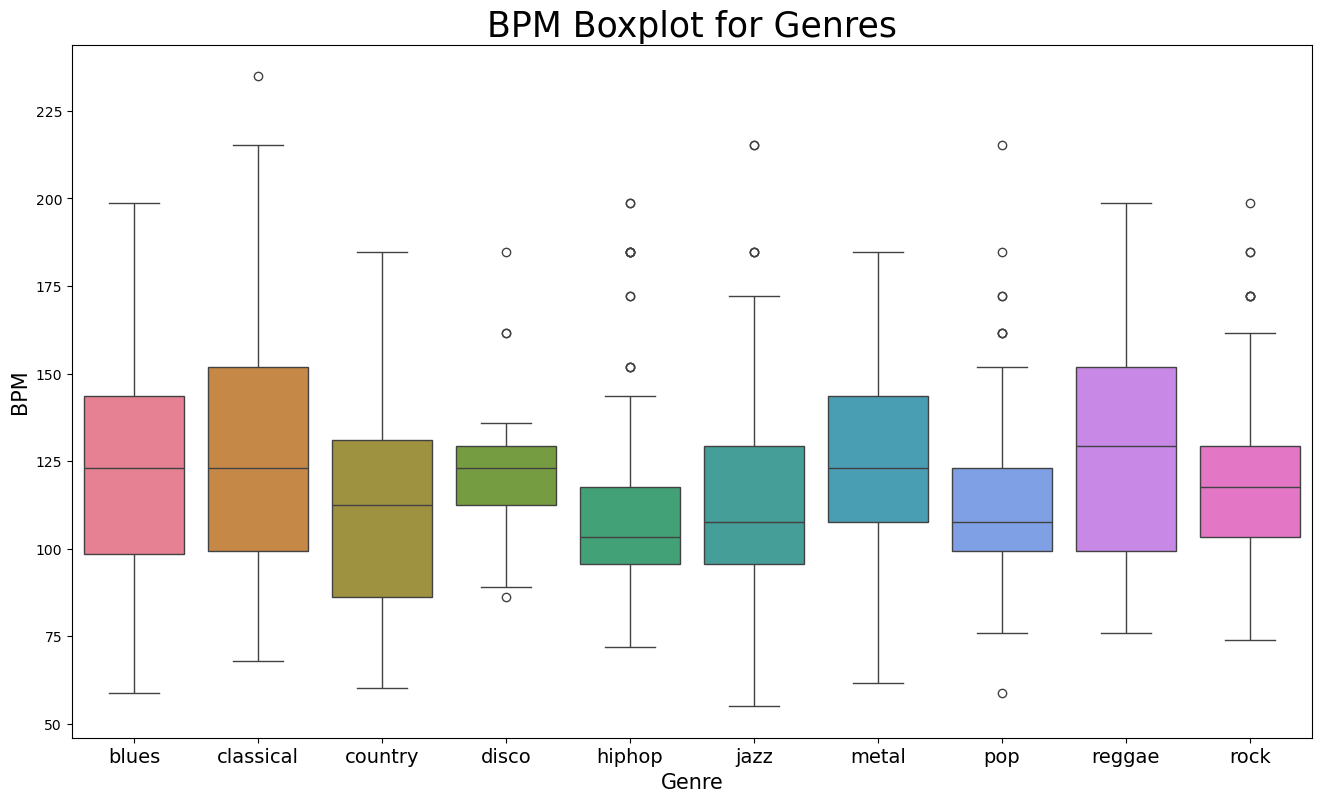

In [26]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize = (16, 9))
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl')

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")